## Amazon Food Reviews - Clustering

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from scipy.sparse import find
from scipy.sparse import csr_matrix
from prettytable import PrettyTable

import collections

import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [6]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [49]:
def sample_reviews(clust_size,clust_data,df_col_name):
    for i in range(clust_size + 1):
        print('Some of the reviews belonging to cluster ',i)
        print('\n')
        print(clust_data.loc[clust_data[df_col_name] == i]['Text'].tolist()[0])
        print('*' * 100)
        print(clust_data.loc[clust_data[df_col_name] == i]['Text'].tolist()[1])
        print('-' * 100)

In [61]:
def points_in_cluster(labels,k_type='kmeans++'):
    a1 = collections.Counter(labels)
    a2 = sorted(a1.items())
    clus_list = []
    for i in range(max(labels)+1):
        b = []
        b.append(a2[i][0])
        if k_type == 'kmedoids':
            b.append(len(a2[i][1]))
        else:
            b.append(a2[i][1])
        clus_list.append(b)
    
    clus_df = pd.DataFrame(clus_list,columns=['Cluster Number', 'Cluster Size'])
    print('Cluster Number and its Sizes')
    return clus_df 
    

In [56]:
def kvalue_vs_loss_plot(k_means_list,errors):
    plt.figure(figsize=(8,4))
    plt.plot(k_means_list,errors,marker = 'o')
    plt.xlabel('K value')
    plt.ylabel('Loss')
    plt.show()
    print('The Optimal no. of Clusters is',np.argmin(errors) + 2)

In [81]:
def kmed_sample_reviews(M,C,clust_data):
    for i in range(len(M)):
        print('Some of the reviews belonging to cluster ',i)
        print('\n')
        print('Review of Central Cluster ',i)
        print(clust_data.iloc[M[i]]['Text'])
        print('*'*100)
        print('A review close to the central cluster ',i)
        print(clust_data.iloc[C[i][0]]['Text'])
        print('-'*100) 

In [9]:
cl_data = load_data('../Amazon_Food_Review_KNN/150k_nb')
cl_data['Score'].value_counts()

1    129548
0     20452
Name: Score, dtype: int64

In [10]:
cl_data_pos = cl_data[cl_data['Score'] == 1][:12500]
cl_data_neg = cl_data[cl_data['Score'] == 0][:12500]
cl_data = pd.concat([cl_data_pos,cl_data_neg])

In [11]:
cl_data = cl_data.drop('Score',axis=1)
cl_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...


### Bag Of Words 

In [12]:
from sklearn.preprocessing import Normalizer
count_vect = CountVectorizer()
x_bow = count_vect.fit_transform(cl_data['Cleaned_Text'].values)
normal_scale = Normalizer().fit(x_bow)
x_bow = normal_scale.transform(x_bow)

### K - Means Clustering

In [13]:
from sklearn.cluster import KMeans

In [14]:
k_means_list = [i for i in range(2,15)]

### Elbow Method to find best K

In [15]:
sq_dist = []
for i in k_means_list:
    model = KMeans(n_clusters = i,n_jobs=-1,verbose= 0 ,n_init = 5,max_iter = 200)
    model.fit(x_bow)
    sq_dist.append(model.inertia_)

In [85]:
save_data(model,'bow_model')
save_data(sq_dist,'bow_errors')

### Plot of K Value vs Loss

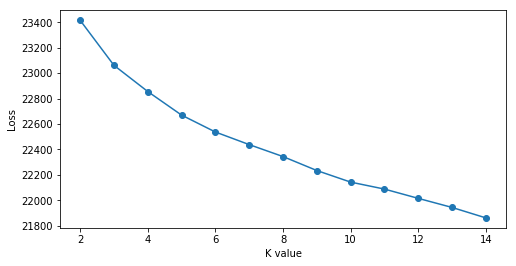

The Optimal no. of Clusters is 14


In [57]:
kvalue_vs_loss_plot(k_means_list,sq_dist)

In [17]:
cl_data['BOW_cluster_labels'] = model.labels_

### No. of Clusters and its Sizes

In [63]:
points_in_cluster(model.labels_)

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,4941
1,1,1866
2,2,1620
3,3,1852
4,4,1036
5,5,1616
6,6,1555
7,7,2056
8,8,1181
9,9,1823


In [19]:
cl_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Cleaned_Text,BOW_cluster_labels
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,0
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,0
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,10
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...,10
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...,10


### Sample Reviews - BOW

In [50]:
sample_reviews(max(model.labels_),cl_data, df_col_name = 'BOW_cluster_labels')

Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Some of the reviews belonging to cluster  1


I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Sho

### K-Medoids - BOW

In [ ]:
# Reference - https://github.com/letiantian/kmedoids.git
!git clone https://github.com/letiantian/kmedoids.git

In [21]:
import os
os.chdir('/Users/sriramthotapallim/kmedoids')
import kmedoids

In [22]:
from sklearn.metrics import pairwise_distances
x_bow1 = x_bow.toarray()
D = pairwise_distances(x_bow1, metric='euclidean')

In [33]:
def kmed_loss(M,C,data):
    a = 0.0
    for i,j in list(C.items()):
        for k in j:
            a = a + ((data[M[i]] - data[k]).sum()) ** 2
    return a 

### Elbow Method to find Best K

In [36]:
kmed_errors = []
for i in k_means_list:
    M,C = kmedoids.kMedoids(D,i)
    kmed_errors.append(kmed_loss(M,C,x_bow1))

In [86]:
save_data(M,'bow_M')
save_data(C,'bow_C')
save_data(kmed_errors,'bow_kmed_errors')

### Plot of K Value vs Loss

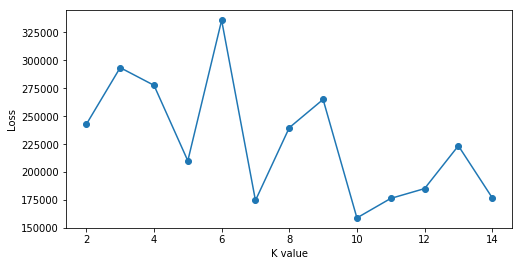

The Optimal no. of Clusters is 10


In [58]:
kvalue_vs_loss_plot(k_means_list,kmed_errors)

### No. of Clusters and its Sizes

In [62]:
points_in_cluster(C,k_type='kmedoids')

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,1117
1,1,1569
2,2,2121
3,3,1404
4,4,2106
5,5,2199
6,6,1968
7,7,2019
8,8,2005
9,9,1054


### K-Medoids Sample Reviews - BOW

In [82]:
kmed_sample_reviews(M,C,cl_data)

Some of the reviews belonging to cluster  0


Review of Central Cluster  0
I was totally satisfied with the ordering of this product.  It was easy to order and my order was filled and shipped quickly.  I will definitely use them again.
****************************************************************************************************
A review close to the central cluster  0
I bought these to decorate some dia de los muertos skulls with icing.  The Ateco food coloring gave nice bright, vibrant colors and mixed with the icing very well. I was totally satisfied with the purchase.
----------------------------------------------------------------------------------------------------
Some of the reviews belonging to cluster  1


Review of Central Cluster  1
This is amazing coffee, you need the machine about $50 to make a good tasting cup of coffee with a nice foam to top it off. I have this coffee, morning and evening, no problems since it is Decaf. buy it yourselves and enjoy a great tasting

### Tf-Idf

In [87]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_bow = tf_idf_vect.fit_transform(cl_data['Cleaned_Text'].values)
normal_scale = Normalizer().fit(x_bow)
x_bow = normal_scale.transform(x_bow)

In [88]:
sq_dist = []
for i in k_means_list:
    model = KMeans(n_clusters = i,n_jobs=-1,verbose= 0 ,n_init = 5,max_iter = 200)
    model.fit(x_bow)
    sq_dist.append(model.inertia_)

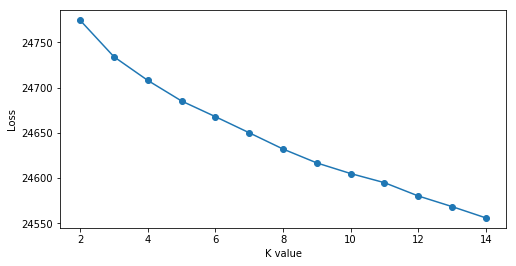

The Optimal no. of Clusters is 14


In [89]:
kvalue_vs_loss_plot(k_means_list,sq_dist)

In [90]:
cl_data['TFIDF_cluster_labels'] = model.labels_

In [91]:
points_in_cluster(model.labels_)

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,377
1,1,478
2,2,7746
3,3,1212
4,4,964
5,5,1449
6,6,653
7,7,1710
8,8,937
9,9,285


In [92]:
sample_reviews(max(model.labels_),cl_data, df_col_name = 'TFIDF_cluster_labels')

Some of the reviews belonging to cluster  0


Looking for a way to live up chicken noodle soup? In lieu of tiny noodles, try Acini Di Pepe. These almost round pices of pasta are the size of tiny BBs. They cook quickly and are fun, yet not too whimsical like alphabet pasta.
****************************************************************************************************
This is so much better than canned stock or boullion cubes that it's unbelievable. It's really like making your own stock. I never use anything else for making French onion soup or vegetable soup. It can be a little salty, and you have to dissolve it in a little hot water before you add it to the soup, but this is one of the things I keep in the house at all times. The lobster stock is great for gumbo, too.
----------------------------------------------------------------------------------------------------
Some of the reviews belonging to cluster  1


Panko bread crumbs are just awesome.  When used for breading they m

### K-Medoids - Tf-Idf

In [93]:
from sklearn.metrics import pairwise_distances
x_bow1 = x_bow.toarray()
D = pairwise_distances(x_bow1, metric='euclidean')

In [94]:
def kmed_loss(M,C,data):
    a = 0.0
    for i,j in list(C.items()):
        for k in j:
            a = a + ((data[M[i]] - data[k]).sum()) ** 2
    return a 

In [95]:
kmed_errors = []
for i in k_means_list:
    M,C = kmedoids.kMedoids(D,i)
    kmed_errors.append(kmed_loss(M,C,x_bow1))

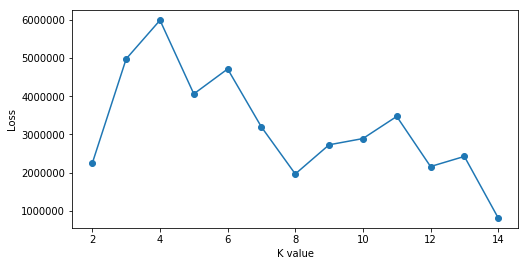

The Optimal no. of Clusters is 14


In [96]:
kvalue_vs_loss_plot(k_means_list,kmed_errors)

In [97]:
points_in_cluster(C,k_type='kmedoids')

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,1600
1,1,392
2,2,790
3,3,2090
4,4,2629
5,5,2512
6,6,782
7,7,1686
8,8,1934
9,9,1115


In [98]:
kmed_sample_reviews(M,C,cl_data)

Some of the reviews belonging to cluster  0


Review of Central Cluster  0
These are really good and I really wish they were good for us.
****************************************************************************************************
A review close to the central cluster  0
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
----------------------------------------------------------------------------------------------------
Some of the reviews belonging to cluster  1


Review of Central Cluster  1
This is so delicioso that I can eat the entire pound by myself.  Just one hint though, if you love to cook (let's say...Lasanga), sprinkle a little Parmigiano Reggiano over the top...try it.  If you're on a diet, this is one heck of a way to break it.
****************************************************************************************************
A review close to the 

### Word2Vec

In [99]:
list_of_train_sent = []
for sent in cl_data['Cleaned_Text'].values:
    list_of_train_sent.append(sent.split())

In [100]:
len(list_of_train_sent)

25000

In [101]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)

In [102]:
w2v_words = list(w2v_model.wv.vocab)

In [103]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [104]:
sent_vectors_arr = np.asarray(sent_vectors)
x_bow = normalize(sent_vectors_arr)

In [105]:
sq_dist = []
for i in k_means_list:
    model = KMeans(n_clusters = i,n_jobs=-1,verbose= 0 ,n_init = 5,max_iter = 200)
    model.fit(x_bow)
    sq_dist.append(model.inertia_)

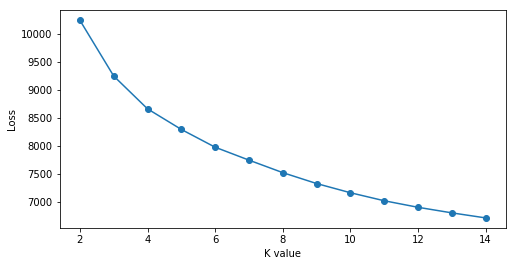

The Optimal no. of Clusters is 14


In [106]:
kvalue_vs_loss_plot(k_means_list,sq_dist)

In [107]:
cl_data['W2V_cluster_labels'] = model.labels_

In [108]:
points_in_cluster(model.labels_)

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,1825
1,1,2700
2,2,1645
3,3,2006
4,4,1381
5,5,1359
6,6,1490
7,7,2654
8,8,1790
9,9,1465


In [109]:
sample_reviews(max(model.labels_),cl_data, df_col_name = 'W2V_cluster_labels')

Some of the reviews belonging to cluster  0


My brother-in-law was thrilled with this gift (and he's Italian!).<br />&gt; Superfast shipping!
****************************************************************************************************
Sure why not. I've purchased plants via catalog for years and it can be frustrating to make the call and then find out that my first three choices are not in stock. Or worse, place the order and find out upon delivery that certain items were out of stock. I like that when purchasing from amazon I know whether or not there is inventory of a particular item before I make the purchase. I haven't pulled the trigger on one of these bonsai's yet, but I'm giving it 5 stars just for the effort. What's next, amazon, livestock?!
----------------------------------------------------------------------------------------------------
Some of the reviews belonging to cluster  1


This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, a

### K-Medoids - W2V

In [111]:
from sklearn.metrics import pairwise_distances
x_bow1 = x_bow
D = pairwise_distances(x_bow1, metric='euclidean')

In [112]:
def kmed_loss(M,C,data):
    a = 0.0
    for i,j in list(C.items()):
        for k in j:
            a = a + ((data[M[i]] - data[k]).sum()) ** 2
    return a 

In [113]:
kmed_errors = []
for i in k_means_list:
    M,C = kmedoids.kMedoids(D,i)
    kmed_errors.append(kmed_loss(M,C,x_bow1))

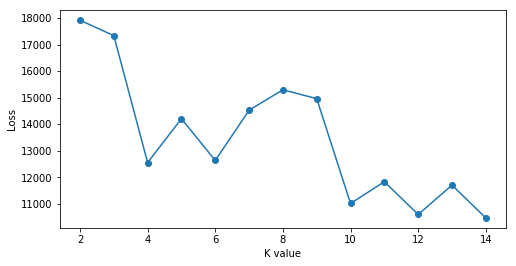

The Optimal no. of Clusters is 14


In [114]:
kvalue_vs_loss_plot(k_means_list,kmed_errors)

In [115]:
points_in_cluster(C,k_type='kmedoids')

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,1497
1,1,1299
2,2,1932
3,3,2830
4,4,1915
5,5,2236
6,6,1261
7,7,642
8,8,1301
9,9,2031


In [116]:
kmed_sample_reviews(M,C,cl_data)

Some of the reviews belonging to cluster  0


Review of Central Cluster  0
Quinoa is one of the healthiest grains you can eat - and one of the most delicious!  It cooks in less than 15 minutes, so you can make a fast dinner using it.  And how delicious it is!  Mmmmmmm!!!!  Softer than rice, it has a slightly sweet and nutty taste.  My favorite recipe is to cook it with a small onion, a tablespoon of butter, and a half cube of vegetarian boullion (or a half-teaspoon if using powdered boullion or fresh refrigerated type).  Bring the water to a boil, add the onion, butter, let boil for a minute.  Then add the quinoa.  Bring to boil again.  Add the bullion, and turn down to a low simmer for 10 - 15 minutes, and there you go!  A fantastic grain that leaves you feeling light and energetic.  As for Bob's products, they are always excellent.  Amazon's price is very good, especially if you live in a small town or out in the country, where it may be hard to get organic and specialty items like B

### Tf-Idf W2V

In [117]:
tf_idf_vect = TfidfVectorizer()
x_bow = tf_idf_vect.fit_transform(cl_data['Cleaned_Text'].values)

In [118]:
dict_svm = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [119]:
from tqdm import tqdm

In [120]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_train_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tf_idf = x_train[row, tfidf_feat.index(word)]
            tf_idf = dict_svm[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 25000/25000 [03:36<00:00, 115.29it/s]


In [121]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_bow = normalize(tfidf_sent_vectors_arr)

In [122]:
sq_dist = []
for i in k_means_list:
    model = KMeans(n_clusters = i,n_jobs=-1,verbose= 0 ,n_init = 5,max_iter = 200)
    model.fit(x_bow)
    sq_dist.append(model.inertia_)

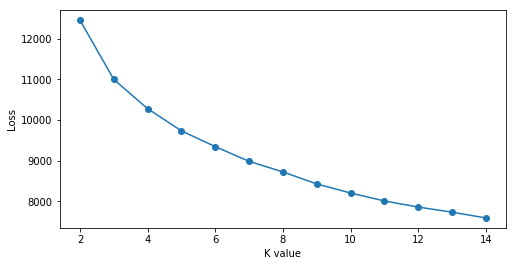

The Optimal no. of Clusters is 14


In [123]:
kvalue_vs_loss_plot(k_means_list,sq_dist)

In [124]:
cl_data['TFIDF_W2V_cluster_labels'] = model.labels_

In [125]:
points_in_cluster(model.labels_)

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,1783
1,1,1895
2,2,2490
3,3,1552
4,4,1493
5,5,1863
6,6,2383
7,7,1687
8,8,1406
9,9,1256


In [126]:
sample_reviews(max(model.labels_),cl_data, df_col_name = 'TFIDF_W2V_cluster_labels')

Some of the reviews belonging to cluster  0


Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
****************************************************************************************************
A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
----------------------------------------------------------------------------------------------------
Some of the reviews belonging to cluster  1


I buy this at our neighborhood supermarket.  It really is the best soymilk - best flavor, best texture, everything.
****************************************************************************************************
I also live in exile in San Francisco, but I'm very loyal to my Miami roots. Pilon Gourmet is the b

### K-Medoids - Tf-Idf W2V

In [127]:
from sklearn.metrics import pairwise_distances
x_bow1 = x_bow
D = pairwise_distances(x_bow1, metric='euclidean')

In [ ]:
def kmed_loss(M,C,data):
    a = 0.0
    for i,j in list(C.items()):
        for k in j:
            a = a + ((data[M[i]] - data[k]).sum()) ** 2
    return a 

In [128]:
kmed_errors = []
for i in k_means_list:
    M,C = kmedoids.kMedoids(D,i)
    kmed_errors.append(kmed_loss(M,C,x_bow1))

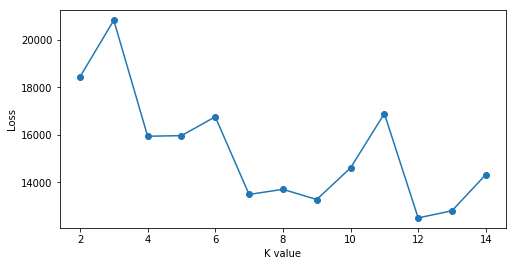

The Optimal no. of Clusters is 12


In [129]:
kvalue_vs_loss_plot(k_means_list,kmed_errors)

In [130]:
points_in_cluster(C,k_type='kmedoids')

Cluster Number and its Sizes


,Cluster Number,Cluster Size
0,0,2147
1,1,2044
2,2,1140
3,3,995
4,4,1550
5,5,1695
6,6,2597
7,7,858
8,8,2429
9,9,1685


In [131]:
kmed_sample_reviews(M,C,cl_data)

Some of the reviews belonging to cluster  0


Review of Central Cluster  0
My cat Foutchie is heading toward 5 now and no one told her the trouble with a kitten is it eventually becomes a cat (so take that Ogden Nash!).  She still voom-voom-vooms around at a pace that makes me exhausted.  She loves toys, especially stuff she chases.  So the bubbles are great full.  Especially since they are catnip bubbles.  You don't have the worry about them getting soap on them and making them sick.  She love jumping high to pop them.<p>So if you are looking for something to awaken the kitten in your kitty, you might try these.
****************************************************************************************************
A review close to the central cluster  0
Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetl